In [100]:
import requests
import time
# URLを指定
html_list =  ['index.html', '00-archives-01.html', '00-archives-02.html', '00-archives-03.html']


def get_html(url):
    base_url = 'https://www.jpx.co.jp/listing/stocks/new/'
    # URLからHTMLコンテンツを取得
    response = requests.get(base_url+url)
    response.encoding = response.apparent_encoding  # この行を追加
    time.sleep(1)
    # ステータスコードが200であれば、内容を取得している
    if response.status_code == 200:
        # レスポンスのHTMLをファイルに保存
        with open(f'/home/mkato/Repository/kabu_analyze/saved_page_{url}', 'w', encoding='utf-8') as file:
            file.write(response.text)
        print("HTMLファイルを保存しました。")
    else:
        print("ウェブページを取得できませんでした。ステータスコード:", response.status_code)

for h in html_list:
    get_html(h)



HTMLファイルを保存しました。
HTMLファイルを保存しました。
HTMLファイルを保存しました。
HTMLファイルを保存しました。


In [178]:
from bs4 import BeautifulSoup

import re
# ファイルを読み込む
def get_stock_code(html):
    with open(f'/home/mkato/Repository/kabu_analyze/saved_page_{html}', 'r', encoding='utf-8') as file:
        html_content = file.read()
    
    # BeautifulSoupオブジェクトを作成し、HTMLを解析する
    soup = BeautifulSoup(html_content, 'html.parser')
    soup = soup.find('div', {'id':'main-area'}).find('tbody').find_all('span')
    code_list = [span['id'] for span in soup]
    soup = BeautifulSoup(html_content, 'html.parser')
    tr_elements = soup.find('tbody').find_all('tr')
    td_elements = [tr_element.find('td', {'rowspan':'2'}) for tr_element in tr_elements]
    # 日付リストを保存するための空のリストを用意
    dates = []
    
    # 各td要素に対してループ処理
    for td in td_elements:
        if td:
            # カッコ内のテキストを除去
            text = re.sub(r'\（.*?\）', '', td.text)
            # チルダがある場合、最初の日付のみ使用
            if '～' in text:
                date = text.split('～')[0].strip()
            else:
                date = text.strip()
            dates.append(date)
    dates = [datetime.strptime(date, '%Y/%m/%d') for date in dates]
    code_list = [code for code, date in zip(code_list, dates) if (datetime.now() - date).days > 21]
    #stock_code_elements = soup.find_all('span', id=True)
    
    # 銘柄コードをリストに保存する
    #stock_codes = [element.get('id') for element in stock_code_elements if element.get('id').isdigit()]
    
    #print("上場された企業の銘柄コードのリスト:", stock_codes)
    return code_list

all_code = []
for h in html_list:

    all_code += get_stock_code(h)
print(len(all_code))

print(all_code)

357
['137A', '138A', '135A', '130A', '5871', '5892', '5870', '9223', '5621', '5869', '5619', '5618', '5868', '5867', '5616', '5599', '5891', '5596', '5597', '5595', '4197', '9238', '5889', '5888', '4811', '9237', '5845', '6525', '9236', '9235', '4896', '5592', '9331', '5843', '6223', '5535', '5844', '6209', '9332', '2938', '5591', '5589', '5590', '6228', '3958', '5588', '9330', '5842', '9168', '5587', '6224', '5586', '9165', '9166', '2962', '5585', '9164', '9163', '5582', '9162', '7409', '9161', '5884', '5885', '9160', '9159', '4893', '5580', '4894', '5533', '9225', '5578', '5532', '5577', '5576', '9158', '5575', '5574', '5572', '7330', '5838', '4040', '5571', '5570', '9348', '5258', '5259', '9347', '5256', '9346', '5257', '9345', '5027', '7163', '5254', '5255', '9344', '5253', '5252', '7119', '9343', '7120', '5250', '5248', '9342', '5461', '5246', '5247', '7115', '7116', '8996', '9340', '9341', '5244', '9339', '2937', '5242', '5243', '5240', '9338', '9337', '5138', '5139', '7114', '51

In [104]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import yfinance as yf
import time
from IPython.display import clear_output

In [116]:
def plt_chart(code):
    ticker = yf.Ticker(code+".T")
    history = ticker.history(period="max")

    # historyが空でないこと、インデックスがDatetimeIndex型であることを確認
    if not history.empty and isinstance(history.index, pd.DatetimeIndex):
        # ローソク図チャートを描画
        mpf.plot(history, type='candle', style='charles',
                 title=code, ylabel='Price (JPY)', datetime_format='%Y-%m')

383/383


/home/mkato/venv/lib/python3.11/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


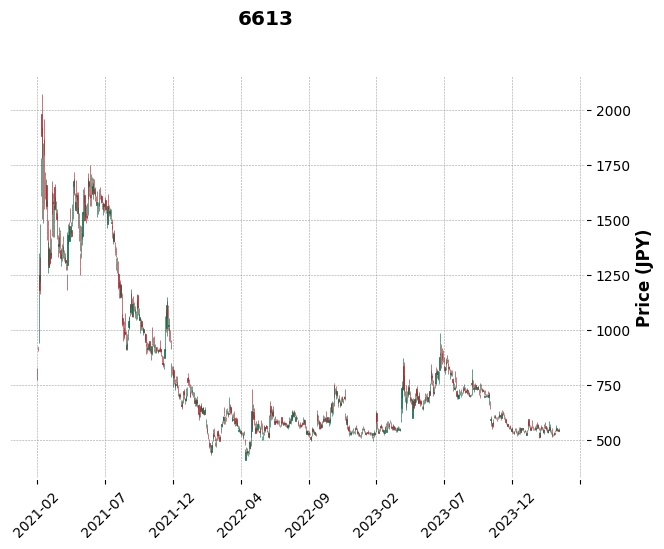

この銘柄のアクション（ｊで永久除外、tで暫定除外、ｇで推奨リスト入り、iで異常データ、それ以外で保留）:  t


リストがテキストファイルに保存されました。


In [114]:
# 除外する銘柄を記録するリスト
deleted_tickers = []
excluded_tickers = []
good_tickers = []
anomaly_tickers = []
etc_tickers = []
index = 0
for code in all_code:
    index += 1
    print(f'{index}/{len(all_code)}')
    clear_output(wait=True)
    plt_chart(code)
        
    # ユーザーに除外するかどうかを尋ねる
    action = input("この銘柄のアクション（ｊで永久除外、tで暫定除外、ｇで推奨リスト入り、iで異常データ、それ以外で保留）: ")
    
    # dが入力された場合、銘柄を除外リストに追加
    if action == 'j':
        deleted_tickers.append(code)
    elif action == 't':
        excluded_tickers.append(code)
    elif action == 'g':
        good_tickers.append(code)
        with open('/home/mkato/Repository/kabu_analyze/good_tickers.txt', 'a') as file:
            file.write(f"{code}\n")
    elif action == 'i':
        anomaly_tickers.append(code)
    else:
        etc_tickers.append(code)

    # ファイルパス
file_path = '/home/mkato/Repository/kabu_analyze/ticker_lists.csv'
    
# 各リストを辞書に格納
lists_dict = {
    "Excluded Tickers": excluded_tickers,
    "Good Tickers": good_tickers,
    "Anomaly Tickers": anomaly_tickers,
    "Etc Tickers": etc_tickers
}

# テキストファイルに保存
with open(file_path, 'w') as file:
    for list_name, tickers in lists_dict.items():
        # リスト名をファイルに書き込み
        file.write(f"{list_name}:\n")
        # 各ティッカーをファイルに書き込み
        for ticker in tickers:
            file.write(f"- {ticker}\n")
        # リスト間に空行を挿入
        file.write("\n")

print("リストがテキストファイルに保存されました。")

383/357


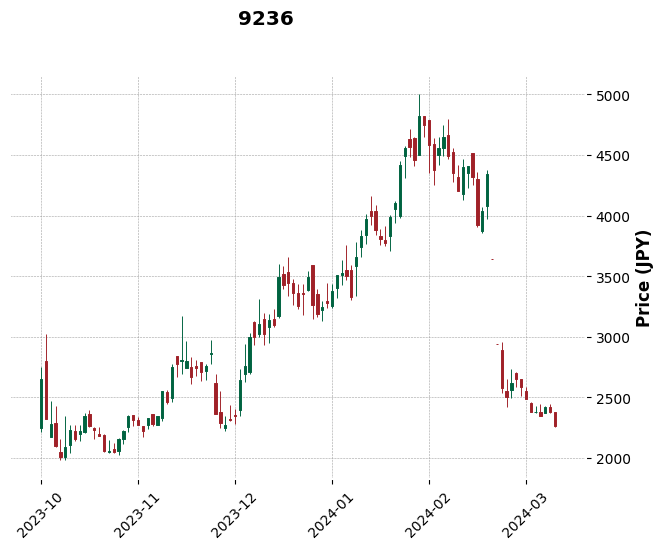

In [ ]:
with open('/home/mkato/Repository/kabu_analyze/all_stock_code_filtered.txt', 'r') as file:
    for line in file:
        clear_output(wait=True)
        plt_chart(line.rstrip())
        action = input("投資対象ならtt")
        if action == 'tt':
            with open('/home/mkato/Repository/kabu_analyze/good_tickers_3rd.txt', 'a') as file:
                file.write(f"{line.rstrip()}\n")

383/383


/home/mkato/venv/lib/python3.11/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


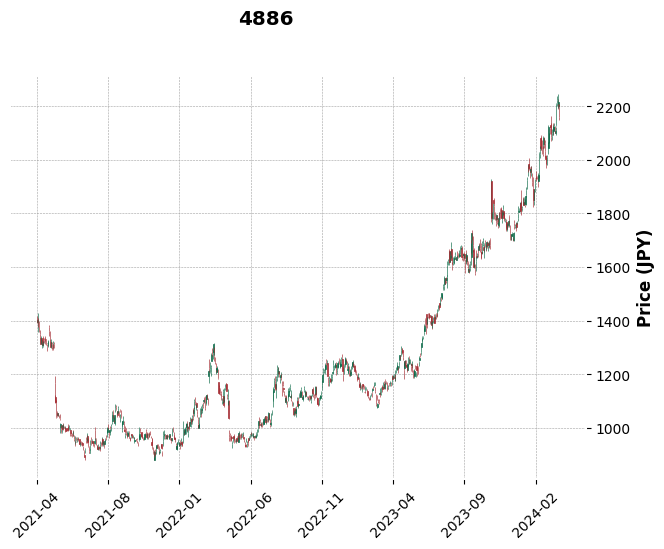

投資対象ならtt tt


In [131]:
with open('/home/mkato/Repository/kabu_analyze/good_tickers_3rd.txt', 'r') as file:
    for line in file:
        clear_output(wait=True)
        plt_chart(line.rstrip())
        action = input("投資対象ならtt")
        if action == 'tt':
            with open('/home/mkato/Repository/kabu_analyze/great_tickers.txt', 'a') as file:
                file.write(f"{line.rstrip()}\n")